In [210]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr
import torch
import torchvision
from pykrx import stock
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta

In [211]:
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using", device)

Using cuda


In [212]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers_rnn, layers_fc):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers_rnn, batch_first=True)
        fclist = []
        for i in range(layers_fc - 1): # layers_fc should be over 1
            fclist.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=True))
            fclist.append(torch.nn.ReLU())
        
        self.fc_seq = torch.nn.Sequential(*fclist)
        self.fc_last = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc_seq(x)
        x = self.fc_last(x[:, -1])
        return x

In [213]:
seq_length = 30
stock_num = 10
train_portion = 0.8
learning_rate = 1e-4

In [214]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [0]]
        dataX.append(_x)
        dataY.append(_y)
    
    return np.array(dataX), np.array(dataY)

In [215]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [216]:
def data_load(stock_dict):
    trainX = []
    testX = []
    trainY = []
    testY = []
    testX_non_scaled = []
    testY_non_scaled = []
    for stock_name in stock_dict:
        input_data = stock_dict[stock_name]['df']
        output_data = stock_dict[stock_name]['target_list']
        input_data = input_data.values[:, 1:].astype(np.float64)
        print(input_data.shape)
        
        train_size = int(len(input_data) * train_portion)
        train_tmp = input_data[0:train_size]
        test_tmp = input_data[train_size - seq_length:]

        testX_non_scaled_tmp, testY_non_scaled_tmp = build_dataset(test_tmp, seq_length)

        train_tmp = minmax_scaler(train_tmp)
        test_tmp = minmax_scaler(test_tmp)

        trainX_tmp, trainY_tmp = build_dataset(train_tmp, seq_length)
        testX_tmp, testY_tmp = build_dataset(test_tmp, seq_length)
        
        trainX_tmp = torch.FloatTensor(trainX_tmp).to(device)
        testX_tmp = torch.FloatTensor(testX_tmp).to(device)
        testX_non_scaled_tmp = torch.FloatTensor(testX_non_scaled_tmp).to(device)
        trainY_tmp = torch.FloatTensor(trainY_tmp).to(device)
        testY_tmp = torch.FloatTensor(testY_tmp).to(device)
        testY_non_scaled_tmp = torch.FloatTensor(testY_non_scaled_tmp).to(device)

        trainX.append(trainX_tmp)
        trainY.append(trainY_tmp)
        testX.append(testX_tmp)
        testY.append(testY_tmp)
        testX_non_scaled.append(testX_non_scaled_tmp)
        testY_non_scaled.append(testY_non_scaled_tmp)
    return trainX, trainY, testX, testY, testX_non_scaled, testY_non_scaled

In [217]:
# 종목 코드 로드
stock_list = pd.read_csv("open/Stock_List.csv")
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x: str(x).zfill(6))


#2-- 종목명을 key로 dict(=stock_dict) 생성
stock_list.set_index("종목명", inplace=True)
selected_codes = stock_list.index.tolist()
stock_list = stock_list.loc[selected_codes]["종목코드"]
stock_dic = dict.fromkeys(selected_codes) 


#3-- 날짜 지정
start_date = '20190101'; end_date = '20211126'  # 2019 01월 01일 ~ 2021년 11월 26일 데이터 load


#4-- Original data loading
for stock_name, stock_code in tqdm(stock_list.items()):
    print("=====", stock_name, "=====")
    business_days = pd.DataFrame(pd.date_range(start_date, end_date, freq='B'), columns=['Date'])

    # 종목 주가 데이터 로드
    try:
        stock_dic[stock_name] = dict.fromkeys(["df", "target_list"])       
        # stock data
        stock_df = stock.get_market_ohlcv_by_date(start_date, end_date, stock_code).reset_index()
        # 기관합계&외국인 합계
        investor_df = stock.get_market_trading_volume_by_date(start_date, end_date, stock_code)[["기관합계", "외국인합계"]].reset_index()
        # kospi 종가
        kospi_df = stock.get_index_ohlcv_by_date(start_date, end_date, "1001")[["종가"]].reset_index()

        # columns name 변경
        stock_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
        investor_df.columns = ["Date", "inst", "fore"]
        kospi_df.columns = ["Date", "kospi"]
        business_days = business_days[business_days["Date"] >= stock_df["Date"][0]]

        # 영업일과 주가 정보를 outer 조인
        train_x = pd.merge(business_days, stock_df, how='left', on="Date")
        train_x = pd.merge(train_x, investor_df, how='left', on="Date")
        train_x = pd.merge(train_x, kospi_df, how='left', on="Date")

        # 앞의 일자로 nan값 forward fill
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].ffill(axis=0)
        # 첫 날이 na 일 가능성이 있으므로 backward fill 수행
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].bfill(axis=0)

    except:
        # 기간&외국인 합계 없는 경우
        stock_dic[stock_name] = dict.fromkeys(["df", "target_list"])
        stock_df = stock.get_market_ohlcv_by_date(start_date, end_date, stock_code).reset_index()
        kospi_df = stock.get_index_ohlcv_by_date(start_date, end_date, "1001")[["종가"]].reset_index()

        stock_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
        kospi_df.columns = ["Date", "kospi"]
        business_days = business_days[business_days["Date"] >= stock_df["Date"][0]]

        # 영업일과 주가 정보를 outer 조인
        train_x = pd.merge(business_days, stock_df, how='left', on="Date")
        train_x = pd.merge(train_x, kospi_df, how='left', on="Date")

        # 앞의 일자로 nan값 forward fill
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].ffill(axis=0)
        # 첫 날이 na 일 가능성이 있으므로 backward fill 수행
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].bfill(axis=0)
    stock_dic[stock_name]["df"] = train_x.copy()


0it [00:00, ?it/s]

===== 삼성전자 =====


1it [00:00,  2.18it/s]

===== SK하이닉스 =====


2it [00:00,  2.42it/s]

===== NAVER =====


3it [00:01,  2.43it/s]

===== 카카오 =====


4it [00:01,  2.61it/s]

===== 삼성바이오로직스 =====


5it [00:01,  2.74it/s]

===== 삼성전자우 =====


6it [00:02,  2.74it/s]

===== LG화학 =====


7it [00:02,  2.82it/s]

===== 삼성SDI =====


8it [00:02,  2.87it/s]

===== 현대차 =====


9it [00:03,  2.91it/s]

===== 셀트리온 =====


10it [00:03,  2.72it/s]


In [218]:
start_date = '2019-01-01'
end_date = '2022-05-01'
forex_index_data = yf.download(["USDKRW=X", "USDAUD=X", "USDJPY=X", "EURUSD=X", "CNY=X", "^GSPC", "^DJI", "^IXIC", "^STOXX50E",
                                "^SOX",  "000001.SS", "000300.SS", "MME=F", "^TNX"], start=start_date, end=end_date, rounding=True)

tmp_forex_index = forex_index_data["Close"]
tmp_forex_index.index = pd.to_datetime(tmp_forex_index.index)
tmp_forex_index = tmp_forex_index[(tmp_forex_index.index >= pd.to_datetime(start_date)) & (tmp_forex_index.index <= pd.to_datetime(end_date))]
tmp_forex_index.columns = ["sse_composite_index", "csi300_index", "usdtocny", "eurtousd", "msci_emerging", "usdtoaud", "usdtojpy", "usdtokrw",
                           "dow", "snp500", "nasdaq", "semicon_index", "euro50", "us10y_tsy"]

tmp_forex_index.reset_index(drop=False, inplace=True)

[*********************100%***********************]  14 of 14 completed


In [219]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [220]:
# ===== feature engineering =====
non_stock = []
corr_list = []
timeunit_gap_forviz = 1
metric_days = 14
cat_vars = []
bin_vars = []
cat_vars.append("weekday")
cat_vars.append("weeknum")
bin_vars.append("mfi_signal")
num_pvalue_check = None
cat_pvalue_check = pd.Series(0, index=["weekday", "weeknum", "mfi_signal"])


for stock_name, stock_data in stock_dic.items():
    train_x = stock_data["df"].copy()

    # 1. 환율 및 관련 인덱스 feature 추가
    train_x = pd.merge(train_x, tmp_forex_index, how="left", on="Date")
    train_x = train_x.ffill() # 과거 일자로 forward fill 수행    
    train_x = train_x.bfill() # 첫 날이 nan 일 가능성이 있으므로 backward fill 수행


    # 2. 요일 및 주차 파생변수 추가
    train_x['weekday'] = train_x["Date"].apply(lambda x: x.weekday())
    train_x['weeknum'] = train_x["Date"].apply(lambda x: week_of_month(x))


    # 3. 거래대금 파생변수 추가
    train_x['trading_amount'] = train_x["Close"] * train_x["Volume"]

    # 4. 월별 주기성 특징을 잡기 위한 sin 및 cos 변환 파생변수 추가
    day_to_sec = 24 * 60 * 60
    month_to_sec = 20 * day_to_sec
    timestamp_s = train_x["Date"].apply(datetime.timestamp)
    timestamp_freq = round((timestamp_s / month_to_sec).diff(20)[20], 1)
    train_x['dayofmonth_freq_sin'] = np.sin((timestamp_s / month_to_sec) * ((2 * np.pi) / timestamp_freq))
    train_x['dayofmonth_freq_cos'] = np.cos((timestamp_s / month_to_sec) * ((2 * np.pi) / timestamp_freq))


    # 5. OBV 파생변수 추가
    # 매수 신호: obv > obv_ema
    # 매도 신호: obv < obv_ema
    obv = [0]
    for i in range(1, len(train_x.Close)):
        if train_x.Close[i] >= train_x.Close[i - 1]:
            obv.append(obv[-1] + train_x.Volume[i])
        elif train_x.Close[i] < train_x.Close[i - 1]:
            obv.append(obv[-1] - train_x.Volume[i])
    train_x['obv'] = obv
    train_x['obv'][0] = np.nan
    train_x['obv_ema'] = train_x['obv'].ewm(com=metric_days, min_periods=metric_days).mean()


    # 6. Stochastic 파생변수 추가
    # fast_d = moving average on fast_k
    # stochastic 관련 지식이 없는데 함수 구현 방법을 알려주지 않아서 넘김
    # train_x[["fast_k", "fast_d"]] = stochastic(train_x, n=metric_days)[["fast_k", "fast_d"]]


    # 7. MFI 파생변수 추가
    # MFI = 100 - (100 / 1 + MFR)
    # MFR = 14일간의 양의 MF / 14일간의 음의 MF
    # MF = 거래량 * (당일고가 + 당일저가 + 당일종가) / 3
    # MF 컬럼 만들기
    train_x["mf"] = train_x["Volume"] * ((train_x["High"]+train_x["Low"]+train_x["Close"]) / 3)
    # 양의 MF와 음의 MF 표기 컬럼 만들기
    p_n = []
    for i in range(len(train_x['mf'])):
        if i == 0 :
            p_n.append(np.nan)
        else:
            if train_x['mf'][i] >= train_x['mf'][i-1]:
                p_n.append('p')
            else:
                p_n.append('n')
    train_x['p_n'] = p_n
    # 14일간 양의 MF/ 14일간 음의 MF 계산하여 컬럼 만들기
    mfr = []
    for i in range(len(train_x['mf'])):
        if i < metric_days-1:
            mfr.append(np.nan)
        else:
            train_x_=train_x.iloc[(i-metric_days+1):i]
            a = (sum(train_x_['mf'][train_x['p_n'] == 'p']) + 1) / (sum(train_x_['mf'][train_x['p_n'] == 'n']) + 10)
            mfr.append(a)
    train_x['mfr'] = mfr
    # 최종 MFI 컬럼 만들기
    train_x['mfi'] = 100 - (100 / (1 + train_x['mfr']))
    train_x["mfi_signal"] = train_x['mfi'].apply(lambda x: 1 if x > 50 else 0) # 1 = buy, 0 = sell


    # 8. 이동평균 추가
    train_x["close_mv5"] = train_x["Close"].rolling(5, min_periods=5).mean()
    train_x["close_mv10"] = train_x["Close"].rolling(10, min_periods=10).mean()
    train_x["close_mv20"] = train_x["Close"].rolling(20, min_periods=20).mean()

    train_x["volume_mv5"] = train_x["Volume"].rolling(5, min_periods=5).mean()
    train_x["volume_mv10"] = train_x["Volume"].rolling(10, min_periods=10).mean()
    train_x["volume_mv20"] = train_x["Volume"].rolling(20, min_periods=20).mean()

    train_x["trading_amount_mv5"] = train_x["trading_amount"].rolling(5, min_periods=5).mean()
    train_x["trading_amount_mv10"] = train_x["trading_amount"].rolling(10, min_periods=10).mean()
    train_x["trading_amount_mv20"] = train_x["trading_amount"].rolling(20, min_periods=20).mean()

    train_x["kospi_mv5"] = train_x["kospi"].rolling(5, min_periods=5).mean()
    train_x["kospi_mv10"] = train_x["kospi"].rolling(10, min_periods=10).mean()
    train_x["kospi_mv20"] = train_x["kospi"].rolling(20, min_periods=20).mean()

    try:
        train_x["inst_mv5"] = train_x["inst"].rolling(5, min_periods=5).mean()
        train_x["inst_mv10"] = train_x["inst"].rolling(10, min_periods=10).mean()
        train_x["inst_mv20"] = train_x["inst"].rolling(20, min_periods=20).mean()

        # 기관 연속 순매수 일자 feature 생성
        cnt_consecutive = 0
        tmp_consecutive = []
        for i in train_x["inst"]:
            if i > 0:
                cnt_consecutive += 1
            else:
                cnt_consecutive = 0
            tmp_consecutive.append(cnt_consecutive)
        train_x["consec_inst"] = tmp_consecutive

        train_x["fore_mv5"] = train_x["fore"].rolling(5, min_periods=5).mean()
        train_x["fore_mv10"] = train_x["fore"].rolling(10, min_periods=10).mean()
        train_x["fore_mv20"] = train_x["fore"].rolling(20, min_periods=20).mean()

        # 외국인 연속 순매수 일자 feature 생성
        cnt_consecutive = 0
        tmp_consecutive = []
        for i in train_x["fore"]:
            if i > 0:
                cnt_consecutive += 1
            else:
                cnt_consecutive = 0
            tmp_consecutive.append(cnt_consecutive)
        train_x["consec_fore"] = tmp_consecutive
    except:
        pass


    # 9. 과거데이터 추가 - RNN이기 때문에 생략함
    # tmp_df = pd.DataFrame()
    # tmp_cols = []
    #1~5일 전 종가 load
    # for i in range(1,6,1):
    #     tmp_df = pd.concat([tmp_df, train_x["Close"].shift(i).to_frame()], axis=1)
    #     tmp_cols.append("close_" + str(i) + "shift")
    # tmp_df.columns = tmp_cols
    # train_x = pd.concat([train_x, tmp_df], axis=1)


    # 10. columns 정리
    # 지표계산을 위해 쓰인 컬럼 drop
    train_x.drop(["mf", "p_n", "mfr"], inplace=True, axis=1)
    # 컬럼이름 소문자 변환 및 정렬
    train_x.columns = train_x.columns.str.lower()
    train_x = pd.concat([train_x[["date"]], train_x.iloc[:,1:].sort_index(axis=1)], axis=1)


    # 11. create target list - build_data 에서 어자피 해결함
    
    # 12. onehot encoding & df save
    # onehot_encoder = MyOneHotEncoder()
    # train_x = onehot_encoder.fit_transform(train_x, cat_vars + bin_vars)
    stock_dic[stock_name]["df"] = train_x.copy()

C:\Users\ParkMinSu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [221]:
print(stock_dic['삼성전자']['df'])
# stock_dic['주식이름']['df] -> 입력 데이터
# stock_dic['주식이름']['target_list'] -> 출력 데이터 (몇일 후의 데이터를 예측하기 위해 target_shift숫자 를 사용하기도 함)

          date    close  close_mv10  close_mv20  close_mv5  consec_fore  \
0   2019-01-02  38750.0         NaN         NaN        NaN            1   
1   2019-01-03  37600.0         NaN         NaN        NaN            2   
2   2019-01-04  37450.0         NaN         NaN        NaN            0   
3   2019-01-07  38750.0         NaN         NaN        NaN            1   
4   2019-01-08  38100.0         NaN         NaN    38130.0            0   
..         ...      ...         ...         ...        ...          ...   
753 2021-11-22  74900.0     71090.0     70790.0    71660.0            2   
754 2021-11-23  75300.0     71570.0     71000.0    72460.0            3   
755 2021-11-24  74800.0     72030.0     71235.0    73280.0            4   
756 2021-11-25  73700.0     72410.0     71385.0    73980.0            0   
757 2021-11-26  72300.0     72580.0     71510.0    74200.0            0   

     consec_inst  csi300_index  dayofmonth_freq_cos  dayofmonth_freq_sin  ...  \
0              0  

In [222]:
# NaN 값이 loss 계산을 Nan으로 만들어버리기에 0으로 채움(추후에 이 값은 바꿀 가능성 높음 -> 가까운 값을 사용하는 것으로 변경(minmax scaler의 효율))
for stock_name in stock_dic:
    stock_dic[stock_name]['df'] = stock_dic[stock_name]['df'].ffill(axis = 0)
    stock_dic[stock_name]['df'] = stock_dic[stock_name]['df'].bfill(axis = 0)

print(stock_dic['삼성전자']['df'])
train_dataX, train_dataY, test_dataX, test_dataY, test_data_non_scaledX, test_data_non_scaledY = data_load(stock_dic)


          date    close  close_mv10  close_mv20  close_mv5  consec_fore  \
0   2019-01-02  38750.0     39170.0     41132.5    38130.0            1   
1   2019-01-03  37600.0     39170.0     41132.5    38130.0            2   
2   2019-01-04  37450.0     39170.0     41132.5    38130.0            0   
3   2019-01-07  38750.0     39170.0     41132.5    38130.0            1   
4   2019-01-08  38100.0     39170.0     41132.5    38130.0            0   
..         ...      ...         ...         ...        ...          ...   
753 2021-11-22  74900.0     71090.0     70790.0    71660.0            2   
754 2021-11-23  75300.0     71570.0     71000.0    72460.0            3   
755 2021-11-24  74800.0     72030.0     71235.0    73280.0            4   
756 2021-11-25  73700.0     72410.0     71385.0    73980.0            0   
757 2021-11-26  72300.0     72580.0     71510.0    74200.0            0   

     consec_inst  csi300_index  dayofmonth_freq_cos  dayofmonth_freq_sin  ...  \
0              0  

In [223]:
i = 3
print(train_dataX[i].shape)
print(train_dataY[i].shape)
print(test_dataX[i].shape)
print(test_dataY[i].shape)

torch.Size([576, 30, 51])
torch.Size([576, 1])
torch.Size([152, 30, 51])
torch.Size([152, 1])


In [224]:
net = Net(51, 16, 1, 1, 3).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [225]:
def train(net, optimizer, epoch, printloss = True):
    for i in range(epoch):
        loss_avg = 0
        for cur_stock in range(stock_num):
            optimizer.zero_grad()
            outputs = net(train_dataX[cur_stock]).to(device)
            loss = criterion(outputs, train_dataY[cur_stock])
            loss.backward()
            optimizer.step()
            loss_avg += loss.item()
        if printloss:
            print('EPOCH :', i, 'loss :', loss_avg/stock_num)
        else:
            if i % 50 == 0:
                print('EPOCH :', i, 'error :', calc_error(net, optimizer))
            

In [226]:
# non scaled
# error = 0

# for cur_stock in range(stock_num):
#     optimizer.zero_grad()
#     outputs = net(test_dataX[cur_stock]).to(device)
#     error += torch.mean(torch.abs(outputs - test_dataY[cur_stock])).item() / stock_num
#      
#     for i in range(len(outputs)):
#         print("pred :", outputs[i].item(), test_dataY[cur_stock][i].item())

# print("Mean Error :", error)

In [227]:
def get_tik(x):
    return 1 + 4 * (x > 1000) + 5 * (x > 5000) + 40 * (x > 10000) + 50 * (x > 50000) + 400 * (x > 100000) + 500 * (x > 500000)

In [228]:
# scaled, tik_fitted
def calc_error(net, optimizer, printenable=False):
    error = 0
    if printenable:
        plt.figure(figsize=(20, 30))

    for cur_stock in range(stock_num):
        optimizer.zero_grad()
        outputs = net(test_dataX[cur_stock])
        max_num = torch.max(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
        min_num = torch.min(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
        outputs = (max_num - min_num) * outputs + min_num
        tik = get_tik(outputs)
        outputs = torch.div(outputs, tik, rounding_mode='floor')
        outputs = outputs * tik
        error += torch.mean(torch.abs(outputs - test_data_non_scaledY[cur_stock])/test_data_non_scaledY[cur_stock]).item() / stock_num
        
        if printenable:
            for i in range(len(outputs)):
                print("pred :", outputs[i].item(), test_data_non_scaledY[cur_stock][i].item())

            plt.subplot(5, 2, cur_stock + 1)
            plt.plot(test_data_non_scaledY[cur_stock].to('cpu'))
            plt.plot(outputs.to('cpu').detach().numpy())
            plt.legend(['original', 'prediction'])
            plt.show
    if printenable:
        print("Mean Error :", error)
    return error

In [238]:
train(net, optimizer, 1000, False)

EPOCH : 0 error : 0.03755451794713735
EPOCH : 50 error : 0.03741805274039507
EPOCH : 100 error : 0.03759054429829121
EPOCH : 150 error : 0.037628340907394885
EPOCH : 200 error : 0.0376787181943655
EPOCH : 250 error : 0.0376377958804369
EPOCH : 300 error : 0.03769500777125359
EPOCH : 350 error : 0.03770914617925882
EPOCH : 400 error : 0.037788406014442444
EPOCH : 450 error : 0.03761537596583366
EPOCH : 500 error : 0.037770393304526806
EPOCH : 550 error : 0.03781053554266691
EPOCH : 600 error : 0.03787885028868914
EPOCH : 650 error : 0.03780202753841877
EPOCH : 700 error : 0.038457279838621614
EPOCH : 750 error : 0.03793065324425697
EPOCH : 800 error : 0.037939205579459664
EPOCH : 850 error : 0.03796246498823166
EPOCH : 900 error : 0.038071734830737114
EPOCH : 950 error : 0.03799971025437116


pred : 84616.6640625 81700.0
pred : 84529.4921875 81500.0
pred : 84344.9609375 81700.0
pred : 84330.3828125 82600.0
pred : 84355.96875 82600.0
pred : 84286.25 82300.0
pred : 84358.21875 81900.0
pred : 84439.5234375 83200.0
pred : 84588.546875 81200.0
pred : 84191.828125 80000.0
pred : 83404.1953125 78500.0
pred : 82354.09375 80100.0
pred : 82716.921875 79600.0
pred : 82911.171875 79600.0
pred : 82773.328125 79600.0
pred : 82329.5234375 79500.0
pred : 82089.765625 80100.0
pred : 82256.7109375 79700.0
pred : 82067.1015625 79900.0
pred : 82025.2109375 79800.0
pred : 81887.359375 79600.0
pred : 81634.8984375 80100.0
pred : 81729.3984375 80500.0
pred : 81690.6875 80600.0
pred : 81712.65625 80800.0
pred : 81700.859375 82800.0
pred : 82144.8046875 82200.0
pred : 81957.328125 81900.0
pred : 81758.3515625 81900.0
pred : 81649.1328125 81100.0
pred : 81433.7109375 81000.0
pred : 81400.5078125 81000.0
pred : 81562.296875 80500.0
pred : 81476.6171875 80900.0
pred : 81530.8125 81800.0
pred : 81775.6

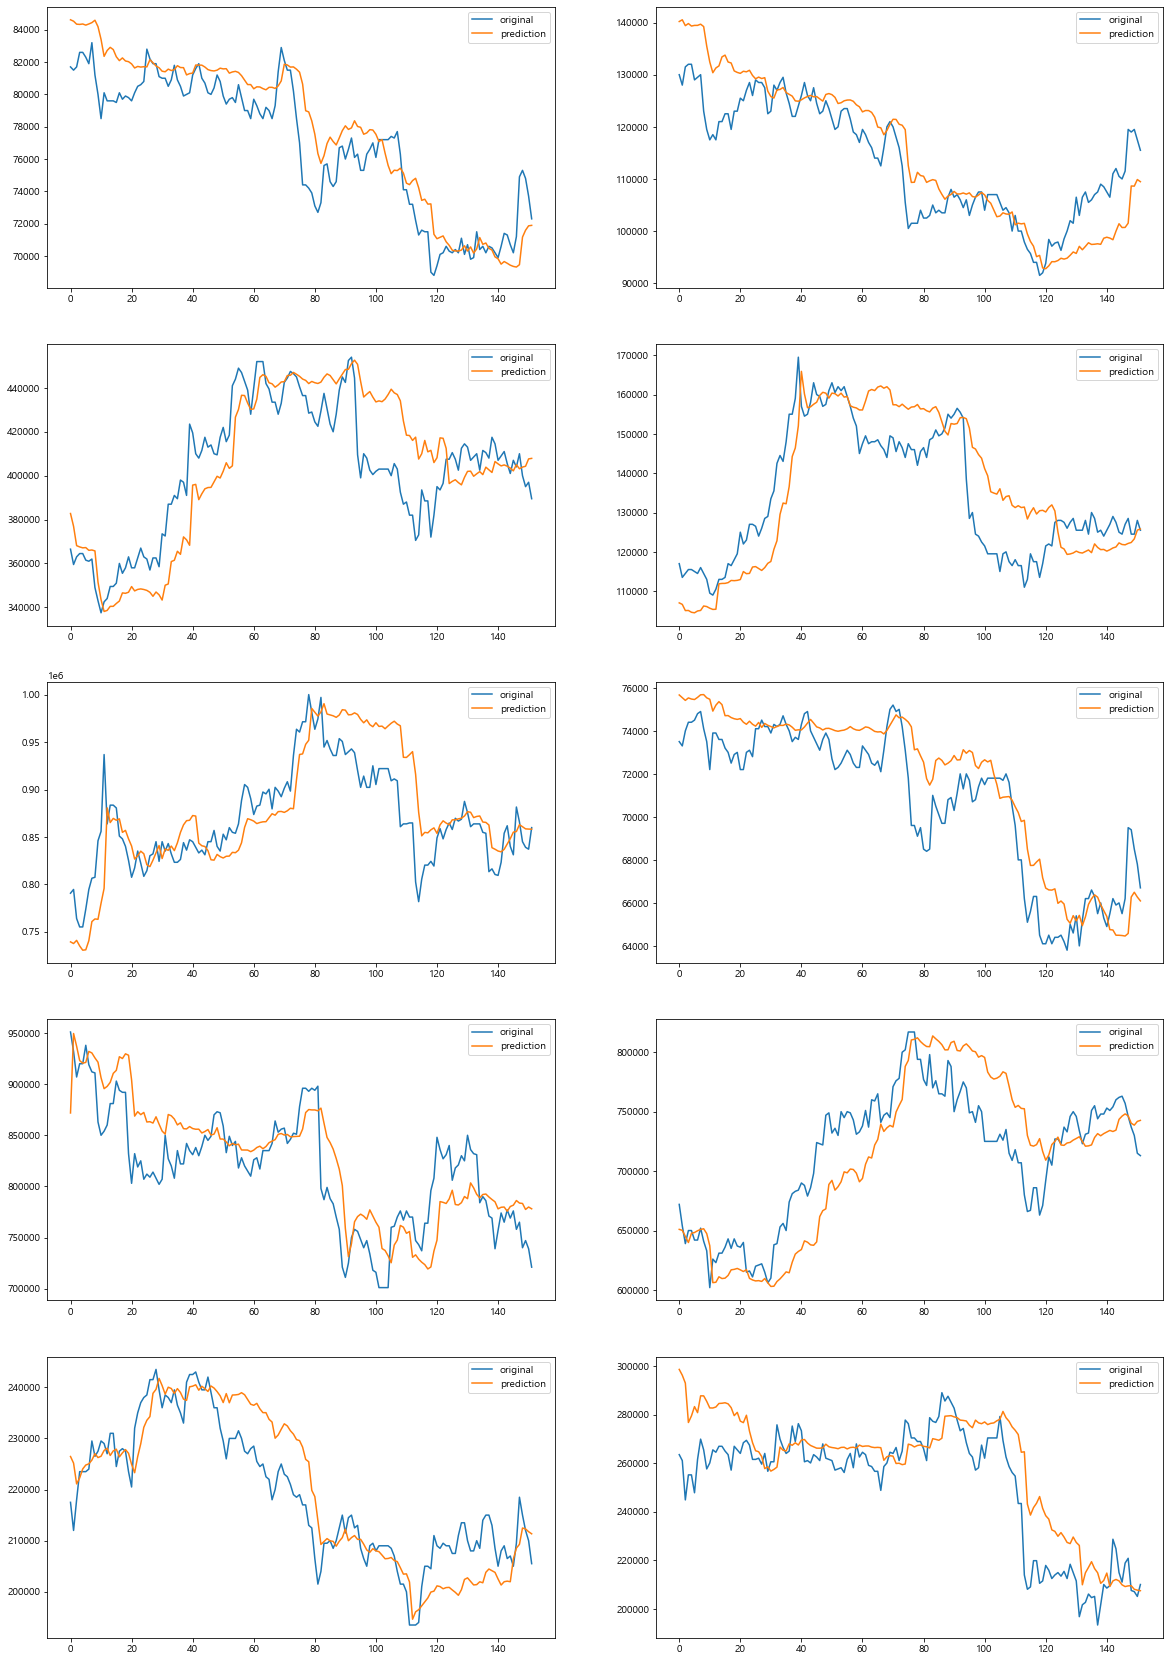

In [239]:
# scaled
error = 0
plt.figure(figsize=(20, 30))

for cur_stock in range(stock_num):
    optimizer.zero_grad()
    outputs = net(test_dataX[cur_stock])
    max_num = torch.max(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
    min_num = torch.min(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
    outputs = (max_num - min_num) * outputs + min_num
    error += torch.mean(torch.abs(outputs - test_data_non_scaledY[cur_stock])/test_data_non_scaledY[cur_stock]).item() / stock_num
    
    for i in range(len(outputs)):
        print("pred :", outputs[i].item(), test_data_non_scaledY[cur_stock][i].item())

    plt.subplot(5, 2, cur_stock + 1)
    plt.plot(test_data_non_scaledY[cur_stock].to('cpu'))
    plt.plot(outputs.to('cpu').detach().numpy())
    plt.legend(['original', 'prediction'])
    plt.show

print("Mean Error :", error)

In [240]:
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, './models/6th_epoch4000_0_038227060623466966.tar')